### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', 50)

### Global & Functions

In [3]:
df = pd.DataFrame()

In [4]:
def checkData(x):
    print(f"\nInfo dos valores:\n")
    print(x.info())
    print(f"\nDescrição dos dados:\n\n{x.describe()}")
    print(f"\nNúmero de nulos por coluna:\n\n{x.isnull().sum()}")
    print(f"\nTipos das colunas:\n\n{x.dtypes}")
    return

def checkCorrelation(x):
    plt.figure(figsize=(10,8))
    sns.heatmap(x.select_dtypes(include=[np.number]).corr(), annot=True)
    plt.show()
    return

def checkOutliers(x):
    """This functions receives a DataFrame and returns a DataFrame with the outliers.
    It takes as premise that the data is normally distributed."""
    dfOutliers  = pd.DataFrame()
    # Itera sobre as colunas númericas
    for column in x.select_dtypes(include=[np.number]).columns:
        # Calcula o 1 quartil (Q1)
        Q1 = x[column].quantile(0.25)
        # Calcula o 3 quartil (Q3)
        Q3 = x[column].quantile(0.75)
        # Calcula o Intervalo Interquartil (IQR)
        IQR = Q3 - Q1
        # Define os limites inferior e superior para outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Identica os outliers da coluna atual e adiciona ao DataFrame de outliers
        outliers = x[(x[column] < lower_bound) | (x[column] > upper_bound)]
        # Concatene os outliers da coluna atual ao DataFrame de outliers
        dfOutliers = pd.concat([df, outliers])
    outliersData = df.drop_duplicates().reset_index(drop=True)
    return outliersData

def checkHist(x):
    """This function receives a DataFrame and returns a histogram of the data."""
    x.hist(bins=50, figsize=(25,10))
    plt.show()
    return

def checkNaN(x):
    """This function receives a DataFrame and returns the count of NaN values for each column."""
    nan_count = x.isna().sum()
    null_count = x.isnull().sum()
    non_null_count = x.notnull().sum()
    print(f"NaN values:\n {nan_count}")
    print(f"Null values:\n {null_count}")
    print(f"Non-null values:\n {non_null_count}")
    return

### Loading data

In [31]:
df_author    = pd.read_csv('dataset/author.csv')
df_award     = pd.read_csv('dataset/award.csv')
df_book      = pd.read_csv('dataset/book.csv')
df_edition   = pd.read_csv('dataset/edition.csv')
df_format    = pd.read_csv('dataset/format.csv')
df_genders   = pd.read_csv('dataset/genders.csv')
df_info      = pd.read_csv('dataset/info.csv')
df_publisher = pd.read_csv('dataset/publisher.csv')
df_ratings   = pd.read_csv('dataset/ratings.csv')
df_sales     = pd.read_csv('dataset/sales.csv')
df_series    = pd.read_csv('dataset/series.csv')

In [32]:
checkNaN(df)

NaN values:
 book_id              0
title                0
author_id            0
birthday             0
country_residence    0
hrs_writing_day      0
award_name           0
year_won             0
publication_date     0
pages                0
print_run_size_k     0
price                0
format               0
volume_number        0
genre                0
pub_name             0
pub_city             0
pub_state            0
pub_country          0
year_established     0
marketing_spend      0
publisher_id         0
series_name          0
rating_mean          0
review_count         0
author_name          0
dtype: int64
Null values:
 book_id              0
title                0
author_id            0
birthday             0
country_residence    0
hrs_writing_day      0
award_name           0
year_won             0
publication_date     0
pages                0
print_run_size_k     0
price                0
format               0
volume_number        0
genre                0
pub_name         

### Cleaning, Transformation and Feature Enginnering

In [16]:
## Concatenating dataframes
df = pd.merge(df_book, df_author, how='left', on='author_id')
cols_new = ['book_id', 'title', 'award_name', 'year_won']
df_award.columns = cols_new
df = pd.merge(df, df_award, how='left', on='book_id')
df = pd.merge(df, df_edition, how='left', on='book_id')
df = pd.merge(df, df_format, how='left', on='format_id')
df = pd.merge(df, df_info, how='left', on='book_id')
df = pd.merge(df, df_genders, how='left', on='genre_id')
df_publisher.drop_duplicates(inplace=True)
df = pd.merge(df, df_publisher, how='left', on='book_id')
df = pd.merge(df, df_series, how='left', on='series_id')
rating_stats = df_ratings.groupby('book_id').agg(
    rating_mean=('rating', 'mean'),
    review_count=('rating', 'count')
).reset_index()
df = pd.merge(df, rating_stats, how='left', on='book_id')

## Clean up dataframe by dropping unnecessary columns and renaming others.
df.drop(columns=['title_y', 'pub_id_x', 'genre_id', 'series_id'], inplace=True)
df.rename(columns={'title_x': 'title', 'pub_id_y': 'publisher_id',
                   'name':'pub_name', 'city':'pub_city', 'state':'pub_state',
                   'country':'pub_country', 'rating_x':'rating_mean',
                   'rating_y':'rating_count', 'genre_desc':'genre',
                   'format_desc':'format'}, inplace=True)
df['author_name'] = df['first_name'] + ' ' + df['last_name']
df.drop(columns=['first_name', 'last_name'], inplace=True)
# Vamos dropar a linha que não possuem publisher nem sale_date
df.dropna(subset=['publisher_id'], inplace=True)
# Vamos dropar a linha que não possuem publisher nem sale_date
df.dropna(subset=['publisher_id'], inplace=True)
# Preencher volume do livro como zero, para aqueles que não possuem continuação
df['volume_number'] = df['volume_number'].fillna(0)
# object to datetime
# Por algum motivo algumas datas estão no formato ANO/MES/DIA
df['birthday'] = pd.to_datetime(df['birthday'], format='%d/%m/%Y')
df['publication_date'] = pd.to_datetime(df['publication_date'], format='%d/%m/%Y')
# float to int
df['year_won'] = df['year_won'].astype('Int64')
df['pages'] = df['pages'].astype('Int64')
df['print_run_size_k'] = df['print_run_size_k'].astype('Int64')
df['volume_number'] = df['volume_number'].astype('Int64')
df['year_established'] = df['year_established'].astype('Int64')
df['review_count'] = df['review_count'].astype('Int64')
df.fillna({"award_name": "none","year_won": 0, "series_name" : "none", "rating_mean" : 0, "review_count" : 0}, inplace=True)

In [ ]:
df_aux = pd.merge(df_sales, df_edition, how='left', on='isbn')
df_aux = pd.merge(df_aux, df_book, how='left', on='book_id')
df.drop(columns=['isbn'], inplace=True)
df_aux.drop(columns=['isbn', 'format_id'], inplace=True)
df_aux.fillna({"discount" : 0, }, inplace=True)
df['sale_date'] = pd.to_datetime(df['sale_date'], format='%d/%m/%Y')
df['pages'] = df['pages'].astype('Int64')
df['print_run_size_k'] = df['print_run_size_k'].astype('Int64')
df['discount'] = df['discount'].replace(',', '.', regex=True)
df['discount'] = df['discount'].astype('float64')

In [29]:
print(checkNaN(df))
df.sample(3)

NaN values:
 book_id              0
title                0
author_id            0
birthday             0
country_residence    0
hrs_writing_day      0
award_name           0
year_won             0
publication_date     0
pages                0
print_run_size_k     0
price                0
format               0
volume_number        0
genre                0
pub_name             0
pub_city             0
pub_state            0
pub_country          0
year_established     0
marketing_spend      0
publisher_id         0
series_name          0
rating_mean          0
review_count         0
author_name          0
dtype: int64
Null values:
 book_id              0
title                0
author_id            0
birthday             0
country_residence    0
hrs_writing_day      0
award_name           0
year_won             0
publication_date     0
pages                0
print_run_size_k     0
price                0
format               0
volume_number        0
genre                0
pub_name         

,book_id,title,author_id,birthday,country_residence,hrs_writing_day,award_name,year_won,publication_date,pages,print_run_size_k,price,format,volume_number,genre,pub_name,pub_city,pub_state,pub_country,year_established,marketing_spend,publisher_id,series_name,rating_mean,review_count,author_name
43,KA663,Kalakalal Avenue,EK605,2129-07-11,Norway,6.0,none,0,2187-05-15,432,25,27.99,Hardcover,0,Fiction,Etaoin Shrdlu Press,Seattle,Washington,USA,1889,2320000.0,ESP,none,4.332367,1035,Elmer Komroff
59,PP866,Portmeirion,BT132,2150-01-28,United States,5.0,Hugo Award,2188,2187-02-20,656,32,21.50,Hardcover,2,SciFi/Fantasy,Etaoin Shrdlu Press,Seattle,Washington,USA,1889,2320000.0,ESP,The Mallemaroking Saga,4.423810,1890,Bianca Thompson
64,SE355,Saint Esme,LD375,2155-08-19,New Zealand,8.0,RITA Award,2189,2188-04-15,336,35,9.50,Mass market paperback,6,Romance,Sound & Seas Co.,Dunedin,Otago,New Zealand,1973,151000.0,SSC,Esme s Ladies,4.337229,1198,Lynne Danticat


In [30]:
print(checkNaN(df_aux))
df_aux.sample(3)


NaN values:
 sale_date           0
discount            0
item_id             0
order_id            0
book_id             0
format_id           0
pub_id              0
publication_date    0
pages               0
print_run_size_k    0
price               0
title               0
author_id           0
dtype: int64
Null values:
 sale_date           0
discount            0
item_id             0
order_id            0
book_id             0
format_id           0
pub_id              0
publication_date    0
pages               0
print_run_size_k    0
price               0
title               0
author_id           0
dtype: int64
Non-null values:
 sale_date           56350
discount            56350
item_id             56350
order_id            56350
book_id             56350
format_id           56350
pub_id              56350
publication_date    56350
pages               56350
print_run_size_k    56350
price               56350
title               56350
author_id           56350
dtype: int64
None


,sale_date,discount,item_id,order_id,book_id,format_id,pub_id,publication_date,pages,print_run_size_k,price,title,author_id
32215,11/8/2193,0,107241-90-1584,107241-28475,NR695,4,ESP,24/9/2182,414,12,8.99,9803 North Millworks Road,CS190
46617,31/10/2193,"0,15",107322-1-8028,107321-41226,TH556,2,ESP,21/12/2182,88,3,23.99,The Startling End of Mr. Hidhoo,JK592
9014,10/4/2193,0,107118-23-9588,107118-7936,AK974,6,CHP,23/7/2182,256,35,11.99,Adventures of Kaya,WH901


### Descrição

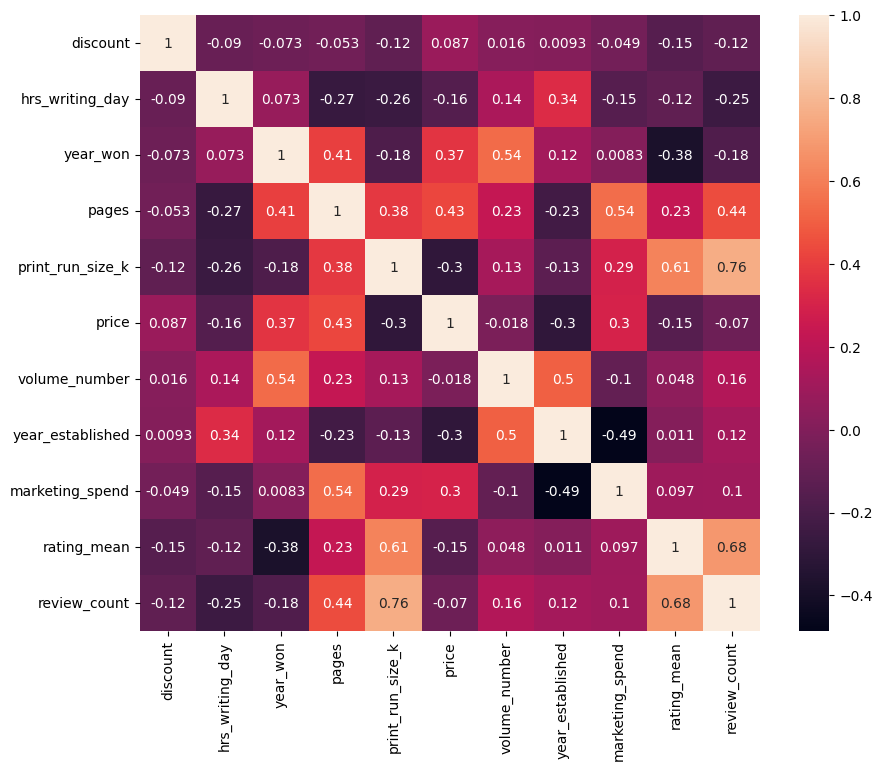

In [11]:
checkCorrelation(df)

In [12]:
checkOutliers(df)

,sale_date,discount,item_id,order_id,book_id,title,author_id,birthday,country_residence,hrs_writing_day,award_name,year_won,publication_date,pages,print_run_size_k,price,format,volume_number,genre,pub_name,pub_city,pub_state,pub_country,year_established,marketing_spend,publisher_id,series_name,rating_mean,review_count,author_name
0,2193-01-02,0.00,107020-91-8011,107020-1,HP265,Heliotrope Pajamas,MW974,2141-01-31,Hong Kong,6.00,Newberry Medal,2182,2188-06-03,16,55,5.99,Board book,0,Childrens,Cedar House Publishers,Friday Harbor,Washington,USA,1906,72000.0,CHP,NaN,4.543651,1764,Malin Wolff
1,2193-01-02,0.00,107020-9-3293,107020-10,TP887,the life and times of an utterly inconsequenti...,DB605,2157-02-26,United States,5.13,PEN/Faulkner Award,2192,2192-08-25,1296,30,13.46,Trade paperback,0,Fiction,Etaoin Shrdlu Press,Seattle,Washington,USA,1889,2320000.0,ESP,NaN,3.195033,1369,David Beam
2,2193-01-02,0.00,107020-91-4622,107020-11,TP887,the life and times of an utterly inconsequenti...,DB605,2157-02-26,United States,5.13,PEN/Faulkner Award,2192,2192-08-25,1296,30,13.46,Trade paperback,0,Fiction,Etaoin Shrdlu Press,Seattle,Washington,USA,1889,2320000.0,ESP,NaN,3.195033,1369,David Beam
3,2193-01-02,0.00,107020-38-4663,107020-12,AY135,And I Said Yes,EK605,2129-07-11,Norway,6.00,NaN,<NA>,2179-04-24,704,15,27.99,Hardcover,0,Fiction,Etaoin Shrdlu Press,Seattle,Washington,USA,1889,2320000.0,ESP,NaN,3.860825,970,Elmer Komroff
4,2193-01-02,0.15,107020-1-1485,107020-13,TC188,Thatchwork Cottage,BM856,2145-01-18,Brazil,6.00,NaN,<NA>,2186-12-05,469,20,12.50,Trade paperback,0,Fiction,Etaoin Shrdlu Press,Seattle,Washington,USA,1889,2320000.0,ESP,NaN,4.210452,708,Burton Malamud
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67918,2193-12-31,0.00,107383-57-1559,107383-49786,LB510,Lace and Brandy,LD375,2155-08-19,New Zealand,8.00,NaN,<NA>,2186-07-25,380,25,9.50,Mass market paperback,5,Romance,Sound & Seas Co.,Dunedin,Otago,New Zealand,1973,151000.0,SSC,Esme s Ladies,4.453271,1284,Lynne Danticat
67919,2193-12-31,0.00,107383-73-7579,107383-49786,AK974,Adventures of Kaya,WH901,2153-10-07,Brazil,7.00,NaN,<NA>,2182-07-23,256,35,11.99,Trade paperback,0,Young Adult,Cedar House Publishers,Friday Harbor,Washington,USA,1906,72000.0,CHP,NaN,4.421885,1517,Ward Haigh
67920,2193-12-31,0.00,107383-54-3838,107383-49787,HP265,Heliotrope Pajamas,MW974,2141-01-31,Hong Kong,6.00,Newberry Medal,2182,2188-06-03,16,55,5.99,Board book,0,Childrens,Cedar House Publishers,Friday Harbor,Washington,USA,1906,72000.0,CHP,NaN,4.543651,1764,Malin Wolff
67921,2193-12-31,0.00,107383-75-7720,107383-49787,BS284,Burnished Silver,LD375,2155-08-19,New Zealand,8.00,NaN,<NA>,2191-09-20,368,37,9.50,Mass market paperback,7,Romance,Sound & Seas Co.,Dunedin,Otago,New Zealand,1973,151000.0,SSC,Esme s Ladies,4.138261,1150,Lynne Danticat


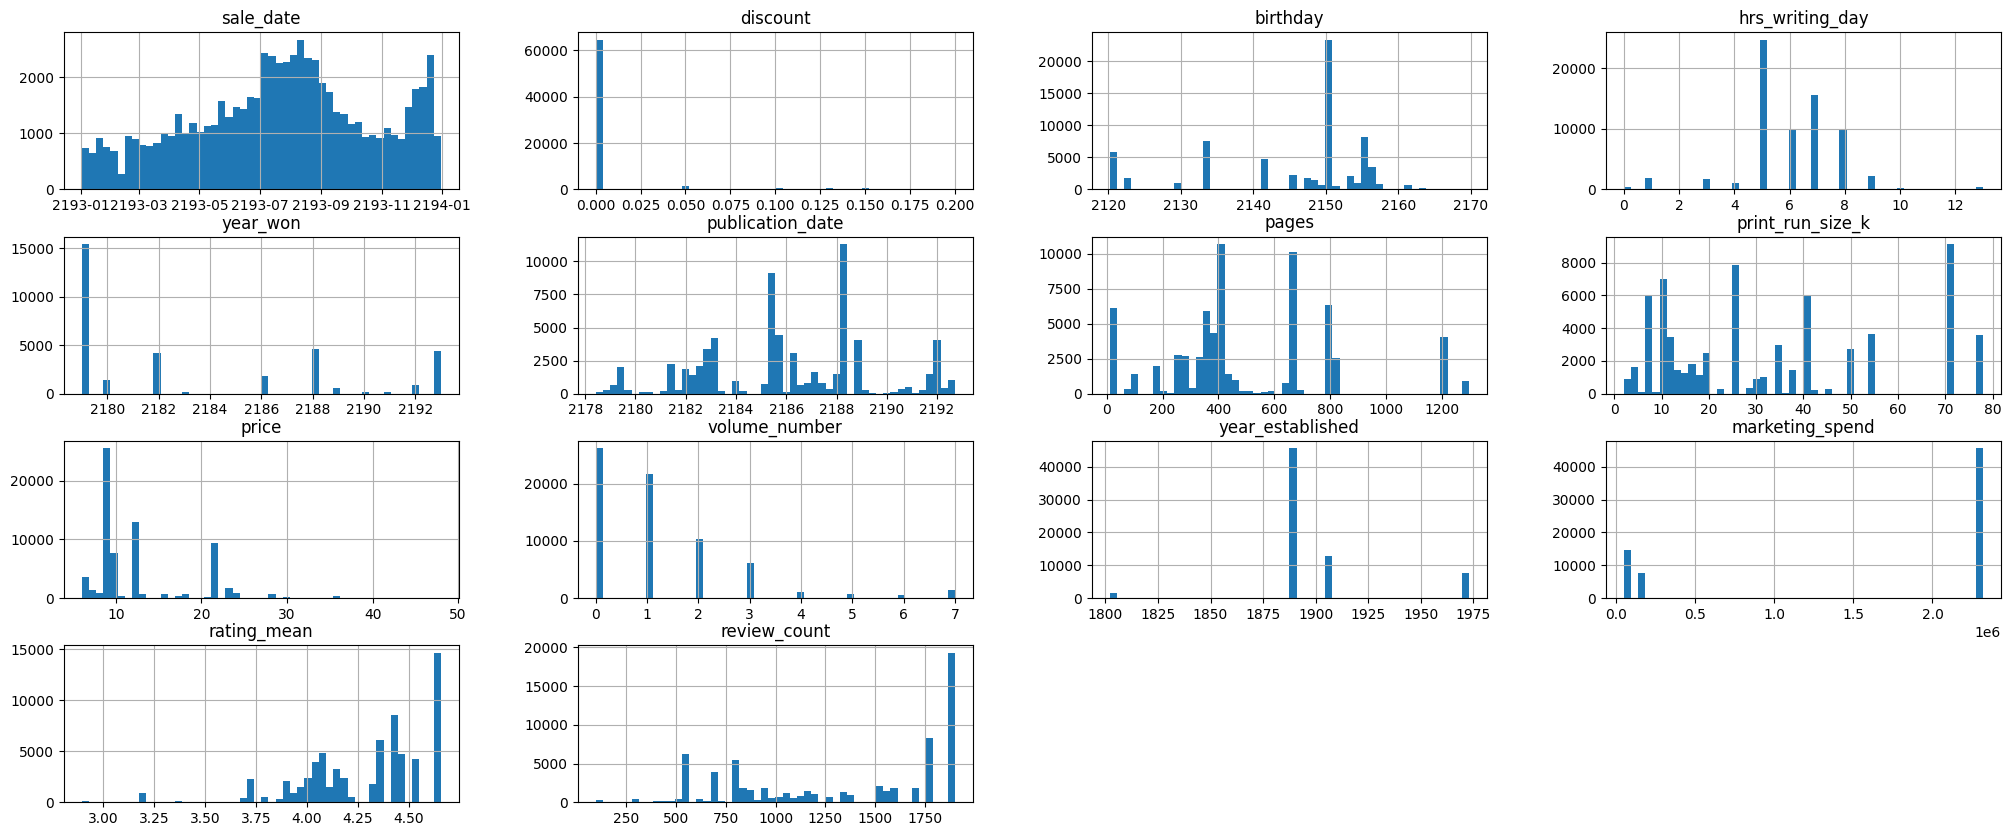

In [13]:
checkHist(df)

### Hipóteses e Conclusões

##### H9 - Livros melhores avaliados vendem mais?
    - Lorem ipsum dolor sit amet, consectetur adipiscing elit.

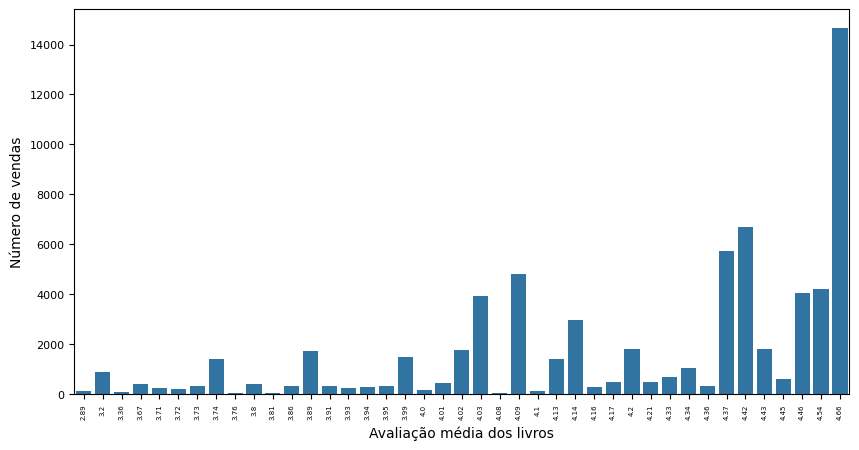

In [14]:
aux = df[['book_id', 'rating_mean']].groupby('book_id').mean().round(2)
aux1 = df[['book_id', 'order_id']].groupby('book_id').count()
a = pd.merge(aux, aux1, how='left', on='book_id').sort_values(by='rating_mean', ascending=False)
b = a.groupby('rating_mean').sum().reset_index()

plt.figure(figsize=(10, 5));
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 8
plt.xticks(rotation=90)
ax = sns.barplot(data=b, x='rating_mean', y='order_id');
ax.set(xlabel='Avaliação média dos livros', ylabel='Número de vendas');

##### H10 - Quantidade de avaliações influenciam na venda?
    - Lorem ipsum dolor sit amet, consectetur adipiscing elit.

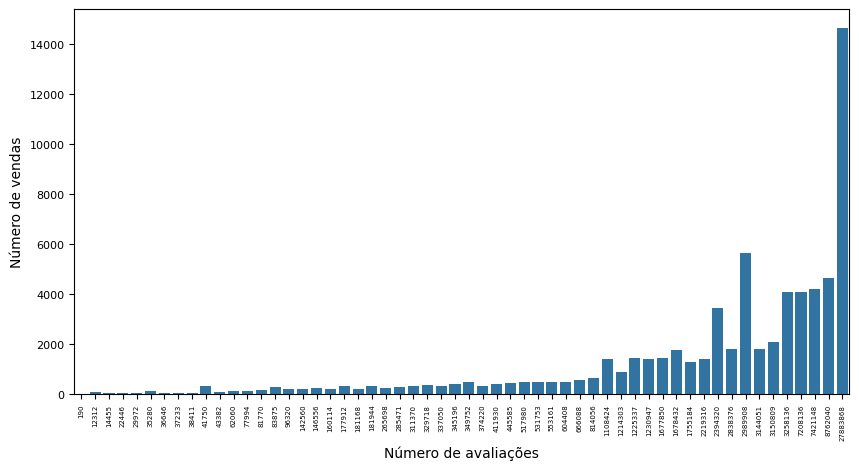

In [15]:
aux = df[['book_id', 'review_count']].groupby('book_id').sum()
aux1 = df[['book_id', 'order_id']].groupby('book_id').count()
a = pd.merge(aux, aux1, how='left', on='book_id')
b = a.groupby('review_count').sum().reset_index()

plt.figure(figsize=(10, 5));
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 8
plt.xticks(rotation=90)
ax = sns.barplot(data=b, x='review_count', y='order_id');
ax.set(xlabel='Número de avaliações', ylabel='Número de vendas');

##### H1 - Autores com mais horas por dia de escrita vendem mais livros?
    - Verdadeiro, pois...

In [16]:
# Quantidade de horas escritas por autor
hrs_per_author = df[['author_name', 'hrs_writing_day']].groupby('author_name').sum().reset_index().sort_values('hrs_writing_day', ascending=False)

# Quantidade de vendas por autor
sales_per_author = df[['author_name', 'item_id']].groupby('author_name').count().reset_index().sort_values('item_id', ascending=False)

# Merge das duas tabelas
author_hrs_sales = pd.merge(hrs_per_author, sales_per_author, how='left', on='author_name')
author_hrs_sales.head()

,author_name,hrs_writing_day,item_id
0,Bianca Thompson,116905.0,23381
1,Lynne Danticat,64296.0,8037
2,Carolyn Segal,52836.0,7548
3,Charles Fenimore,40754.0,5822
4,Malin Wolff,28152.0,4692


Text(0.5, 1.0, 'Hours Writing Day vs Number of Sales')

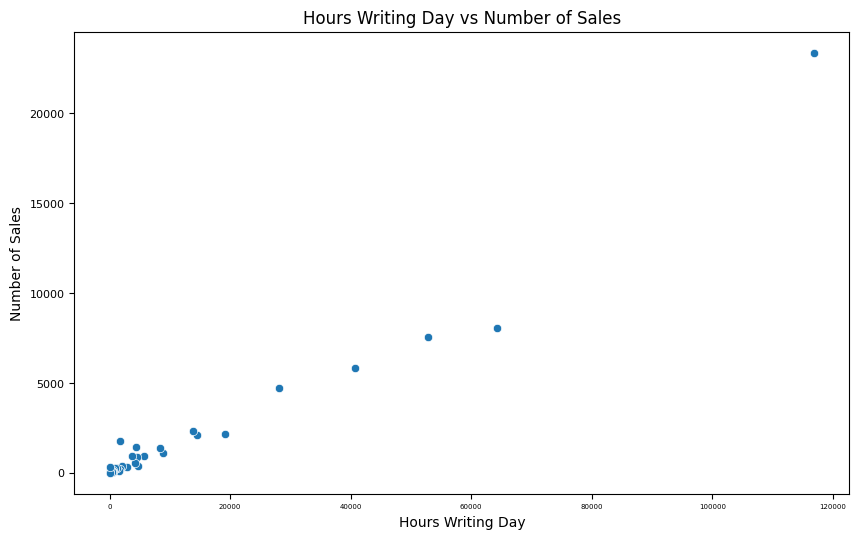

In [17]:
# Mostrar o gráfico de horas escritas por dia x número de vendas
plt.figure(figsize=(10, 6))
sns.scatterplot(x='hrs_writing_day', y='item_id', data=author_hrs_sales)
plt.xlabel('Hours Writing Day')
plt.ylabel('Number of Sales')
plt.title('Hours Writing Day vs Number of Sales')

##### H2 - Autores britanicos vendem mais livros?
    - Falso, os americanos vendem mais, como pode ser visto no gráfico abaixo.

   country_residence  books_sold
11     United States       34010
6        New Zealand       10744
7             Norway        6835
4          Hong Kong        6172
0             Brazil        4904
10    United Kingdom        2483
2              China        1455
1             Canada         577
9       South Africa         275
5        Netherlands         266
8          Singapore         126
3            Germany          76


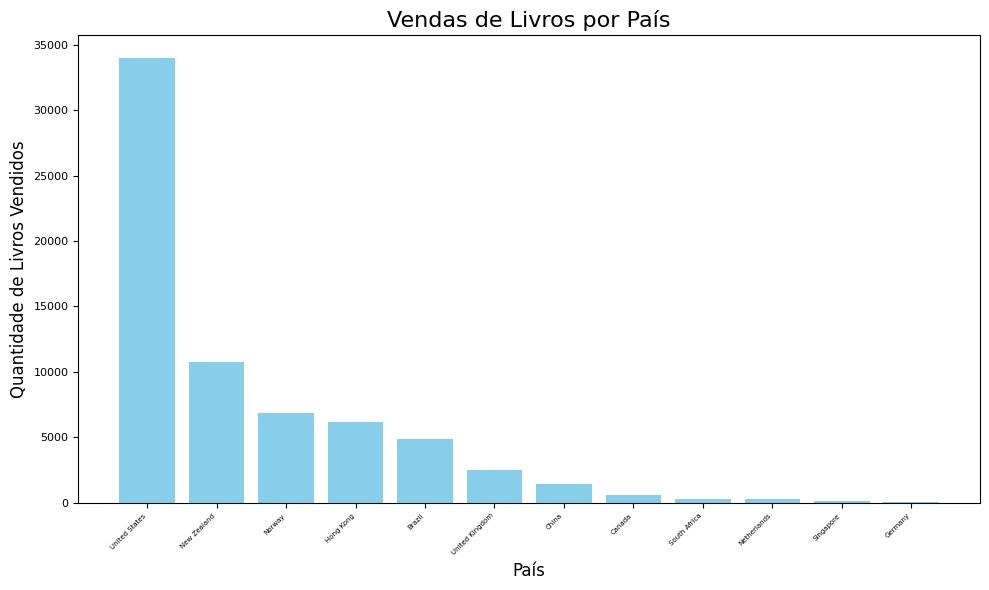

In [18]:
# Lista de nacionalidades
nacionalidades = [
    'United States', 'Brazil', 'South Africa', 'Norway', 'New Zealand',
    'Hong Kong', 'China', 'Netherlands', 'United Kingdom', 'Canada',
    'Germany', 'Singapore'
]

# Filtrar os dados com base nas nacionalidades e contar vendas
sales_by_country = (df[df['country_residence'].isin(nacionalidades)]
                    .groupby('country_residence')['item_id'].count()
                    .reset_index().rename(columns={'item_id': 'books_sold'})
                    .sort_values(by='books_sold', ascending=False))

# Exibir a tabela
print(sales_by_country)

# Plotar o gráfico
plt.figure(figsize=(10, 6))
plt.bar(sales_by_country['country_residence'], sales_by_country['books_sold'], color='skyblue')
plt.title('Vendas de Livros por País', fontsize=16)
plt.xlabel('País', fontsize=12)
plt.ylabel('Quantidade de Livros Vendidos', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### H3 - Autores mais velhos vendem mais livros?
    **Séria bom explicar a escala dessa idade no gráfico ou normalizar**
    - Falso, não foi notado nenhuma correlação entre vendas e idade dos autores.
    

    relative_age  books_sold
0              0        5822
1            984        1778
2           3402         942
3           3660          59
4           4938        7548
5           7624        4692
6           8536          59
7           9072        2309
8           9536         126
9           9870        1396
10          9966          71
11         10059         342
12         10222        1433
13         10262          58
14         10737         293
15         10748         116
16         10753         261
17         10908       23381
18         11279          76
19         11338         518
20         12256        2077
21         12407         930
22         12937        8037
23         12947         208
24         13127        2131
25         13238         215
26         13334        1103
27         13459           2
28         13494         887
29         14848         362
30         14996         353
31         15895         275
32         18092          63


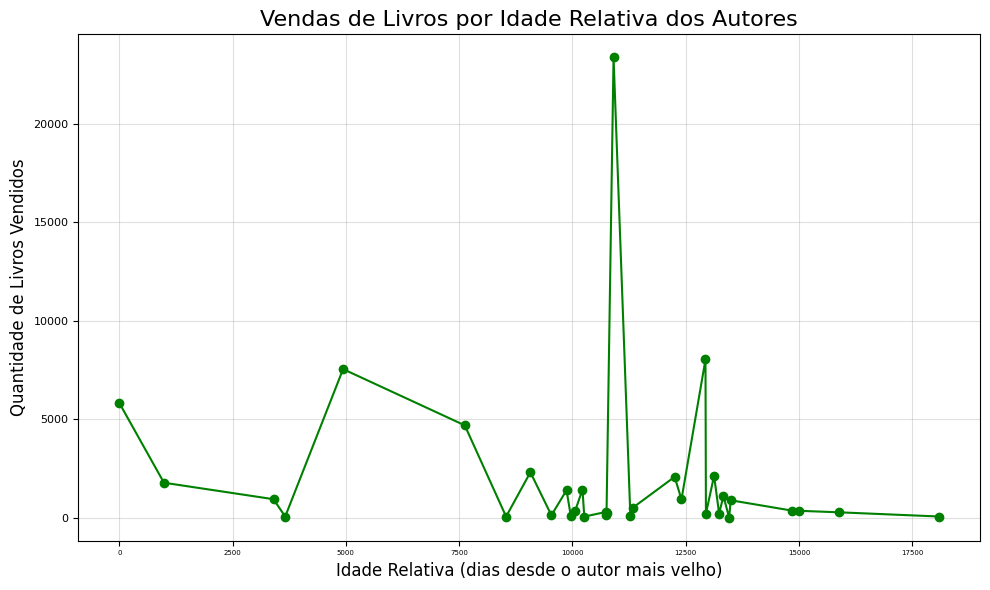

In [19]:
# Calcular a idade relativa (autor mais velho como referência)
oldest_birthday = df['birthday'].min()  # Data de nascimento mais antiga
df['relative_age'] = (df['birthday'] - oldest_birthday).dt.days

# Agrupar por idade relativa e contar as vendas
sales_by_age = (df.groupby('relative_age')['item_id'].count().reset_index()
                .rename(columns={'item_id': 'books_sold'})
                .sort_values(by='relative_age', ascending=True)  # Ordenar do mais velho para o mais novo
)

# Exibir a tabela
print(sales_by_age)

# Plotar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(sales_by_age['relative_age'], sales_by_age['books_sold'], marker='o', linestyle='-', color='green')
plt.title('Vendas de Livros por Idade Relativa dos Autores', fontsize=16)
plt.xlabel('Idade Relativa (dias desde o autor mais velho)', fontsize=12)
plt.ylabel('Quantidade de Livros Vendidos', fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

##### H11 - Editoras mais antigas vendem mais?
    - Lorem ipsum dolor sit amet, consectetur adipiscing elit.

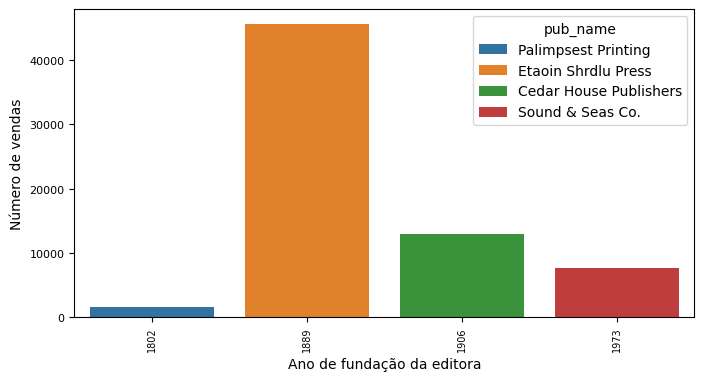

In [20]:
plt.figure(figsize=(8, 4));
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 8
plt.xticks(rotation=90)
ax = sns.countplot(data=df, x='year_established', hue='pub_name');
ax.set(xlabel='Ano de fundação da editora', ylabel='Número de vendas');

##### H12 - País da editora influencia nas vendas?
    - Lorem ipsum dolor sit amet, consectetur adipiscing elit.

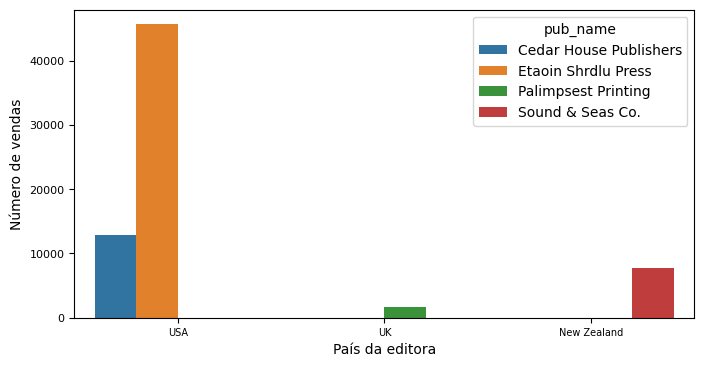

In [21]:
plt.figure(figsize=(8, 4));
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 8
ax = sns.countplot(data=df, x='pub_country', hue='pub_name');
ax.set(xlabel='País da editora', ylabel='Número de vendas');

##### H4 - Autores com mais livros lançados vendem mais?
    **Observações: aqui acho que vale a pena tentar normalizar os dados das vendas, pois do jeito que está sendo feito, pode haver uma distorção dos resultados. Por exemplo, autor1 lança 1 livro e tem 20 vendas, e autor2 lança 5 livros e tem 50 vendas, o autor 1 pode ter vendido menor número de copias, mas ele tem uma porcentagem melhor de "aproveitamento" do que o autor 2. Então talvez seja interessante normalizar as vendas pelo número de livros lançados para ver se a correlação ainda é verdadeira.**
    - Verdadeiro. Há uma correlação positiva entre a quantidade de livros lançados por um autor e as vendas desses livros.
    - Tirando um "outlier" de 8 livros lançados, há uma tendencia de crescimento.

            author_name  total_books  total_sales
23       Lynne Danticat            8         8037
10        Elmer Komroff            3          942
4        Burton Malamud            3         2309
11         Gloria Green            3         1103
3       Bianca Thompson            3        23381
31      Ursula Karénine            2         2131
13    Hillary Barnhardt            2          930
6      Charles Fenimore            2         5822
15     John W. Spanogle            2          293
5         Carolyn Segal            2         7548
24          Malin Wolff            2         4692
17       Kathy Yglesias            2          518
30      Robert Plimpton            2          362
0    Abraham Stackhouse            1           71
8            David Beam            1          887
2          Bernard Hopf            1         1778
7     Clifford Wolitzer            1           59
16  Jonathan Kotzwinkle            1           76
14    Jill Hergesheimer            1          215


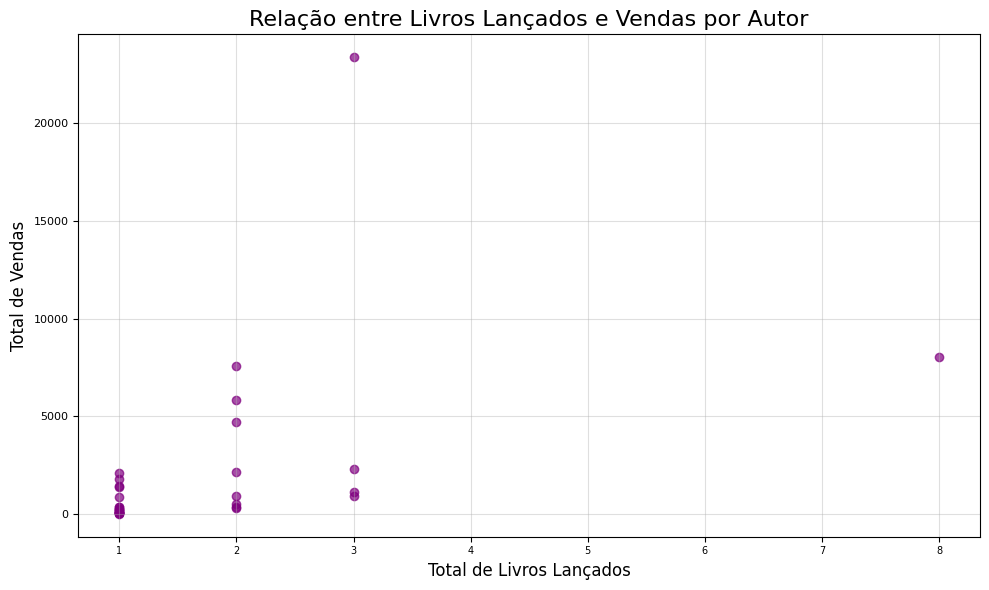

In [22]:
# Contar o número de livros lançados por autor
books_per_author = df.groupby('author_name')['book_id'].nunique().reset_index()
books_per_author = books_per_author.rename(columns={'book_id': 'total_books'})

# Contar o número total de vendas por autor
sales_per_author = df.groupby('author_name')['item_id'].count().reset_index()
sales_per_author = sales_per_author.rename(columns={'item_id': 'total_sales'})

# Merge das tabelas para comparar livros lançados e vendas
author_analysis = pd.merge(books_per_author, sales_per_author, on='author_name')

# Calcular a correlação entre total de livros lançados e vendas
correlation = author_analysis['total_books'].corr(author_analysis['total_sales'])

# Exibir a tabela e a correlação
print(author_analysis.sort_values('total_books', ascending=False))
print(f"Correlação entre número de livros lançados e vendas: {correlation:.2f}")

# Plotar o gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(author_analysis['total_books'], author_analysis['total_sales'], alpha=0.7, color='purple')
plt.title('Relação entre Livros Lançados e Vendas por Autor', fontsize=16)
plt.xlabel('Total de Livros Lançados', fontsize=12)
plt.ylabel('Total de Vendas', fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

##### H16 - Descontos são eficazes em aumentar as vendas?
    - Analisar se há uma correlação entre o uso de descontos e as vendas totais.
    - Se houver uma correlação positiva, isso sugere que os descontos são eficazes em aumentar as vendas.
    - Caso contrário, pode ser necessário revisar a estratégia de promoção.

In [23]:
df_sales

,sale_date,isbn,discount,item_id,order_id
0,2/1/2193,989-28-3705-007-2,NaN,107020-91-8011,107020-1
1,2/1/2193,989-28-79-11297-4,NaN,107020-9-3293,107020-10
2,2/1/2193,989-28-79-11297-4,NaN,107020-91-4622,107020-11
3,2/1/2193,989-28-79-18127-7,NaN,107020-38-4663,107020-12
4,2/1/2193,989-28-79-82197-5,"0,15",107020-1-1485,107020-13
...,...,...,...,...,...
56345,31/12/2193,989-28-229-5891-8,NaN,107383-57-1559,107383-49786
56346,31/12/2193,989-28-3705-222-9,NaN,107383-73-7579,107383-49786
56347,31/12/2193,989-28-3705-007-2,NaN,107383-54-3838,107383-49787
56348,31/12/2193,989-28-229-9769-6,NaN,107383-75-7720,107383-49787


In [24]:
df_edition

,isbn,book_id,format_id,pub_id,publication_date,pages,print_run_size_k,price
0,989-28-79-70597-8,TT359,3,ESP,2/6/2178,277,15,27.99
1,989-28-654-6930-3,NP937,3,PP,18/8/2178,394,6,30.99
2,989-28-79-52883-6,PA169,3,PP,8/9/2178,384,10,27.99
3,989-28-79-43574-5,TM925,2,ESP,15/9/2178,187,8,23.99
4,989-28-654-5794-2,HS107,3,PP,29/9/2178,640,3,26.99
...,...,...,...,...,...,...,...,...
90,989-28-654-6507-7,SS693,6,PP,15/5/2192,387,8,15.99
91,989-28-79-03683-6,TA182,3,ESP,3/7/2192,340,35,18.50
92,989-28-654-3899-6,WK456,3,PP,14/8/2192,207,2,29.99
93,989-28-79-11297-4,TP887,6,ESP,25/8/2192,1296,30,13.46


In [25]:
dftest = pd.merge(df_book, df_author, how='left', on='author_id')
print(dftest)

   book_id                                              title author_id  \
0    AD222                               Alanna Saves the Day     BH149   
1    AK974                                 Adventures of Kaya     WH901   
2    AM124      A Horrible Human with the Habits of a Monster     KD840   
3    AY135                                     And I Said Yes     EK605   
4    BB194                                      Ballinby Boys     AM329   
5    BC244                       Banana Slug and the Lost Cow     HB302   
6    BF374                        Banana Slug and Xyr Friends     HB302   
7    BF889                Banana Slug and the Glass Half Full     GG800   
8    BR858                     Banana Slug and the Mossy Rock     MW974   
9    BS284                                   Burnished Silver     LD375   
10   CC830                                           Cimornul     JH502   
11   CH391                                   Can I Be Honest?     CF829   
12   CP573               

##### H28 - Os melhores autores de cada gênero vendem mais?
    - Comparar as vendas totais dos autores de cada gênero para identificar quais são os melhores vendedores em cada categoria.
    - Se a premissa de que promoções são eficazes for verdadeira, então poderia se organizar uma campanha com os melhores autores de cada gênero.